In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
from tdwg_lib.split_step_solver import BPMSplitStepSolver
import tdwg_lib.ftutils_torch as ftutils
from tdwg_lib.beam_utils import gaussian_beam, make_HG_modes
from tdwg_lib.waveguide import Waveguide
from tdwg_lib.pnn_utils import L2, has_converged
from tdwg_lib.helpers import smoothen2d, timestring
from tdwg_lib.pat import make_pat_func
from tdwg_lib import pnn_utils 

# Parameters

In [3]:
NMODES = 2  # Number of input/output modes

# Waveguide parameters
LAMBDA0 = 1.55  # Free-space wavelength in μm
K0 = 2*np.pi/LAMBDA0  # Free-space wavenumber in μm⁻¹
NEFF = 1.8  # Effective refractive index of slab mode

# Transverse (x) axis
LX = 500  # Width of simulation area in μm
NX = 2**9  # Number of grid points in transverse dimension
DX = LX/(NX-1)  # Grid spacing in transverse dimension in μm
X_AXIS = ftutils.ft_t_axis(NX, DX)  # Centered frequency-domain axis

# Propagation (z) axis
DZ = 50  # Propagation step size in μm
LZ = 10000  # Total propagation length in μm
NZ = int(np.floor(LZ/DZ))  # Number of propagation steps
Z_AXIS = (torch.arange(NZ)+1)*DZ  # Propagation coordinate starting at DZ

# Mode properties
MODE_X_MIN = -50 * (NMODES-1)  # Center position of leftmost input mode in μm
MODE_X_MAX = 50 * (NMODES-1)  # Center position of rightmost input mode in μm
W0 = 20  # Beam waist (1/e² radius) in μm

# Training parameters
DELTA_N_VAL = 1e-3  # Maximum refractive index change
ITERATIONS = 100  # Number of training epochs
LR = 0.5e-1  # Learning rate for optimizer
GAMMA = 0.99  # Learning rate decay factor
BATCH_SIZE = NMODES  # Batch size for training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available

# Waveguide container object stores simulation geometry and parameters
wg = Waveguide(NEFF, X_AXIS, Z_AXIS, device=DEVICE)

## Define input and output modes

In [4]:
# Input modes: Gaussian beams evenly spaced from MODE_X_MIN to MODE_X_MAX
INPUT_MODES = torch.vstack([gaussian_beam(X_AXIS, mu, W0) for mu in np.linspace(MODE_X_MIN, MODE_X_MAX, NMODES)])

# Output modes: Hermite-Gauss modes centered at x=0
OUTPUT_MODES = make_HG_modes(X_AXIS, x_center=0, w0=W0, n=NMODES)

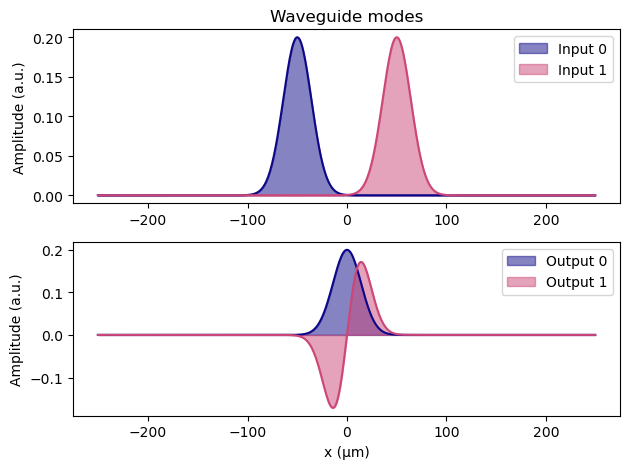

In [5]:
# Plot input modes
plt.subplot(2, 1, 1)
for ind_mode, mode in enumerate(INPUT_MODES):
    # Use .real to plot real part of complex field (modes are real-valued)
    plt.fill_between(X_AXIS, mode.real, label=f'Input {ind_mode}', color=cm.plasma(ind_mode/NMODES), alpha=0.5)
    plt.plot(X_AXIS, mode.real, color=cm.plasma(ind_mode/NMODES))

plt.legend(loc='upper right')
plt.title('Waveguide modes')
plt.ylabel('Amplitude (a.u.)')

# Plot output modes
plt.subplot(2, 1, 2)
for ind_mode, mode in enumerate(OUTPUT_MODES):
    # Use .real to plot real part of complex field (modes are real-valued)
    plt.fill_between(X_AXIS, mode.real, label=f'Output {ind_mode}', color=cm.plasma(ind_mode/NMODES), alpha=0.5)
    plt.plot(X_AXIS, mode.real, color=cm.plasma(ind_mode/NMODES))

plt.legend(loc='upper right')
plt.xlabel('x (μm)')
plt.ylabel('Amplitude (a.u.)')

plt.tight_layout()


In [6]:
# Define target unitary transformation: identity matrix maps each input to corresponding output
# (input 0 → output 0, input 1 → output 1, etc.)
U_TARGET = torch.eye(NMODES, dtype=torch.complex64, device=DEVICE)

## Create trainable 2D waveguide class as pytorch.nn.Module 

In [7]:
class TDwgNet(nn.Module):
    def __init__(self, solver, wg, delta_n_val, input_modes, output_modes, device, res_x=6, res_z=6):
        super(TDwgNet, self).__init__()
        self.device = device
        
        # Initialize trainable modulation parameter with bounds [0.05, 0.95]
        mod = 0.5*torch.ones([wg.Nz, wg.Nx], requires_grad=True, dtype=torch.float32).to(self.device)
        self.mod = pnn_utils.Parameter(mod, limits=[0.05, 0.95])
        
        self.delta_n_val = delta_n_val  # Maximum refractive index change
        self.scale_x = res_x  # Resolution limit in x-direction (smoothing scale)
        self.scale_z = res_z  # Resolution limit in z-direction (smoothing scale)
        
        self.input_modes = input_modes.to(dtype=torch.complex64).to(self.device)
        self.output_modes = output_modes.to(dtype=torch.complex64).to(self.device)
        
        self.wg = wg
        self.solver = solver

    def forward(self, x, monitor=False):
        # Clip modulation to valid range and apply smoothing filter to emulate finite resolution
        mod = self.mod.clip(0., 1.)
        mod = smoothen2d(self.wg.x_axis, self.wg.z_axis, mod, scale_x=self.scale_x, scale_z=self.scale_z)

        # Project input coefficients onto input mode basis
        inputs = x.to(self.device) @ self.input_modes
        
        # Compute refractive index distribution: background + modulated perturbation
        delta_n = self.wg.background_delta_n + self.delta_n_val*mod
        
        # Propagate through waveguide
        output_beams = self.solver.run_simulation(inputs, delta_n, monitor)
        
        # Project output fields onto output mode basis (overlap integral with dx scaling)
        a_out = output_beams @ self.output_modes.T * self.wg.dx
        return a_out

## Training loop

In [8]:
# Initialize beam propagation method solver
bpmsolver = BPMSplitStepSolver(X_AXIS, Z_AXIS, NEFF)

# Create 2D-waveguide object with trainable index modulation
tdwg_pnn = TDwgNet(bpmsolver, wg, DELTA_N_VAL, INPUT_MODES, OUTPUT_MODES, DEVICE)

# Setup Adam optimizer
optimizer = optim.Adam(tdwg_pnn.parameters(), lr=LR)

# Setup learning rate scheduler with exponential decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

# Set model to training mode
tdwg_pnn.train()

TDwgNet()

In [9]:
PRINT_INTERVAL = 10  # Print loss every N iterations

loss_list = []
n = len(tdwg_pnn.input_modes)  # Number of modes
indices = np.arange(n)  # Create array of mode indices
# Split indices into batches for mini-batch training
batch_indices = np.array_split(indices, np.ceil(n / BATCH_SIZE))

for i in range(ITERATIONS):
    optimizer.zero_grad()  # Reset gradients

    # Loop over batches
    for indices in batch_indices:
        # Forward pass: compute numerical unitary for this batch
        U_num = tdwg_pnn.forward(torch.eye(n, dtype=torch.complex64)[indices])
        
        # Objective loss: L2 distance between numerical and target unitary
        l_objective = L2(U_TARGET[indices], U_num)

        # Lagrangian penalty: enforce parameter bounds (limiting largest refractive index change)
        l_lagrange = pnn_utils.lagrangian(tdwg_pnn, lag_amp=1, factor=20)
        
        # Total loss
        l = l_objective + l_lagrange
        l.backward()  # Compute gradients
        
    optimizer.step()  # Update parameters
    scheduler.step()  # Decay learning rate
    loss_list.append(l.detach().cpu().data)

    # Print progress
    if i % PRINT_INTERVAL == 0:
        print(timestring() + f"--Iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
    
    # Early stopping if converged
    if has_converged(loss_list):
        print(timestring() + f"Converged at iteration: {i}, Loss: {l.detach().cpu().data:.5f}")
        break

/vast/palmer/home.grace/mms266/2D-waveguide-demo-code/tdwg_lib/split_step_solver.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dz = torch.tensor(self.dz, device=device, dtype=delta_n.dtype)


2025-10-04--15-46-46--Iteration: 0, Loss: 0.49991
2025-10-04--15-46-47--Iteration: 10, Loss: 0.05114
2025-10-04--15-46-47--Iteration: 20, Loss: 0.02177
2025-10-04--15-46-47--Iteration: 30, Loss: 0.00455
2025-10-04--15-46-48--Iteration: 40, Loss: 0.00350
2025-10-04--15-46-48--Iteration: 50, Loss: 0.00145
2025-10-04--15-46-48--Iteration: 60, Loss: 0.00101
2025-10-04--15-46-49--Iteration: 70, Loss: 0.00071
2025-10-04--15-46-49--Iteration: 80, Loss: 0.00057
2025-10-04--15-46-50--Iteration: 90, Loss: 0.00052


Text(0, 0.5, 'Loss')

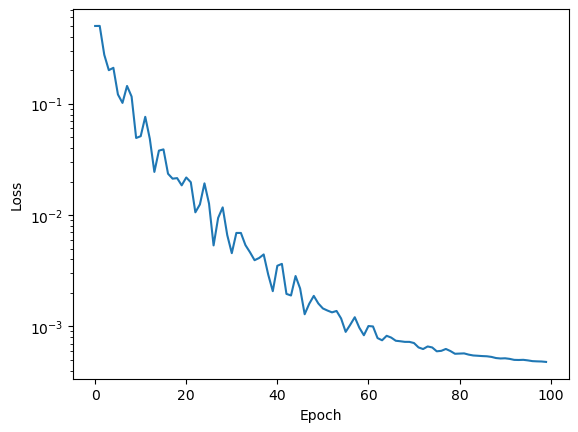

In [10]:
# Plot training loss history
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [11]:
# Perform forward pass with monitor=True to store internal optical fields for visualization
with torch.no_grad():
    U_num_inv = tdwg_pnn.forward(torch.eye(NMODES, dtype=torch.complex64), monitor=True)

# Compute relative error: mean absolute difference normalized by target magnitude
avg_error_inv = torch.mean(torch.abs(U_num_inv - U_TARGET)) / torch.mean(torch.abs(U_TARGET)) * 100
print(f"Average error for inverse design: {avg_error_inv:.2f}%")

Average error for inverse design: 2.24%


## Plot results

In [12]:
def plot_delta_n(z_axis, x_axis, delta_n, vmax):
    figsize_deltan = (2*3, 2*1.5*3/5)  # Figure size in inches
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    
    # Plot refractive index: convert z to mm, take real part, transpose for (x, z) orientation
    img = plt.pcolormesh(z_axis/1000, x_axis, np.real(delta_n.T), cmap="Greens", vmax=vmax, vmin=0)
    
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (μm)")
    plt.title(r"$\Delta n(x, z)$")
    plt.colorbar()

    plt.show()

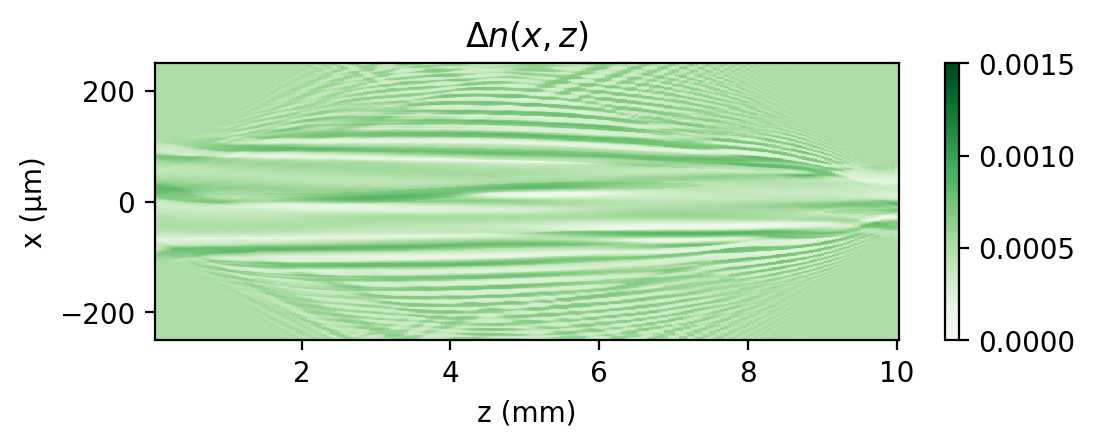

In [13]:
# Extract optimized refractive index: clip and scale trained modulation parameter
delta_n_inv = DELTA_N_VAL * (torch.clip(tdwg_pnn.mod.detach().cpu(), 0., 1.))

# Plot optimized refractive index distribution
plot_delta_n(wg.z_axis, wg.x_axis, delta_n_inv, 1.5*DELTA_N_VAL)

In [14]:
def plot_intensity(z_axis, x_axis, Imat_x, title=None):
    figsize_deltan = (2*3, 2*1.5*3/5)  # Figure size in inches
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    
    # Plot intensity: convert z to mm, transpose for (x, z) orientation
    img = plt.pcolormesh(z_axis/1000, x_axis, Imat_x, cmap="Reds")
    
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (μm)")
    plt.title(title if title is not None else r"$I(x, z)$")
    plt.colorbar()

    plt.show()

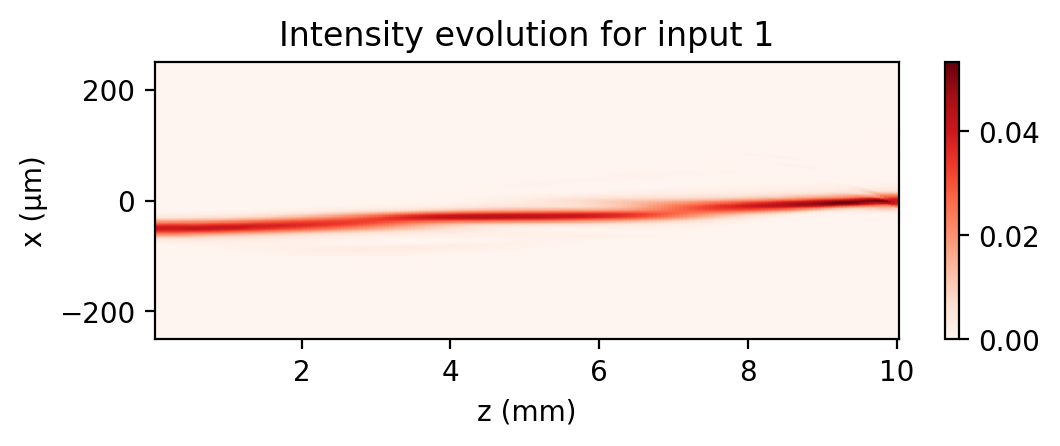

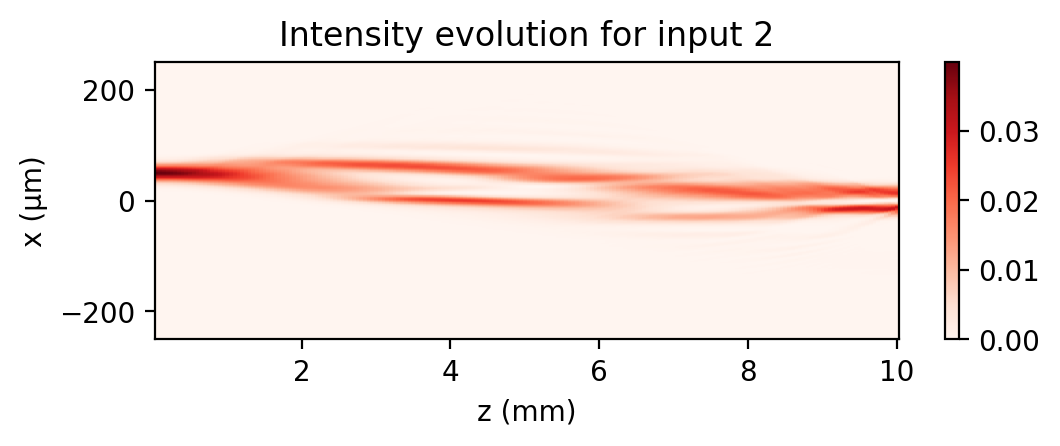

In [15]:
# Plot intensity distribution for each mode
for ind in range(NMODES):
    # Extract electric field for this mode from solver
    Emat_x = tdwg_pnn.solver.Emat_x[:, ind].cpu().detach()
    
    # Compute intensity: |E|²
    Imat_x = Emat_x.abs().square()
    
    # Downsample z-axis based on monitor interval (Ncom)
    z_list = Z_AXIS[::tdwg_pnn.solver.Ncom]
    
    # Plot intensity distribution with mode number (1-indexed for display)
    plot_intensity(z_list, X_AXIS, Imat_x.T, title=f"Intensity evolution for input {ind+1}")